In [1]:
%pylab inline

from ipywidgets import widgets, IntSlider, Label
from IPython.display import display

from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

Populating the interactive namespace from numpy and matplotlib


In [2]:
def graph(t, solution):
    #t = np.linspace(t_0,t_p,ts)
    fig = plt.figure(1, figsize=(14,18), dpi= 80, facecolor='w', edgecolor='k')
    #axes = plt.gca()
    #axes.set_yscale('log')

    # Plot cMa as a function of time
    ax1 = fig.add_subplot(311)
    ax1.plot(t, solution[:,0], label='Atmosphere')
    # Plot cMcc as a function of time
    ax2 = fig.add_subplot(311)
    ax2.plot(t, solution[:,1], label='Continental Crust')

    # Plot cMm as a function of time
    ax3 = fig.add_subplot(311)
    ax3.plot(t, solution[:,2], label='Mantle')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Mass of Carbon')
    
    ax4 = fig.add_subplot(311)
    ax4.plot()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
    #plt.xlim([2,2.02])
    #plt.ylim([0,1e5])
    plt.show()

At $t_0 \le t < t_1$, 

\begin{array}
  {\partial M_a}\over{\partial t} &= \frac{^cM_m}{^cM_{mp}} ^cF_{(m-a)p} e^{\frac{t_p - t}{t_f}} - 0, \\
  \frac{\partial M_{cc}}{\partial t} &= 0 - \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} e^{\frac{t_p - t}{t_f}}, \\
  \frac{\partial M_{m}}{\partial t} &= ( \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} -\frac{^cM_m}{^cM_{mp}} ^cF_{(m-a)p} ) e^{\frac{t_p - t}{t_f}}
\end{array}

At $t_1 \le t < t_2$, 

\begin{array}
  {\partial M_a}\over{\partial t} &= \frac{^cM_m}{^cM_{mp}} ^cF_{(m-a)p} e^{\frac{t_p - t}{t_f}} - \frac{^cM_{a0}}{\tau_1}, \\
  \frac{\partial M_{cc}}{\partial t} &= \frac{^cM_{a0}}{\tau_1} - \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} e^{\frac{t_p - t}{t_f}}, \\
  \frac{\partial M_{m}}{\partial t} &= ( \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} -\frac{^cM_m}{^cM_{mp}} ^cF_{(m-a)p} ) e^{\frac{t_p - t}{t_f}}
\end{array}

At $t_2 \le t < t_p$, 

\begin{array}
  {\partial M_a}\over{\partial t} &= 0, \\
  \frac{\partial M_{cc}}{\partial t} &= 0 - \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} e^{\frac{t_p - t}{t_f}}, \\
  \frac{\partial M_{m}}{\partial t} &= ( \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} ) e^{\frac{t_p - t}{t_f}}
\end{array}

where

\begin{array}
    ^cF_{(m-a)p} &= 13 \quad \text{Mt/yr}, \\
    ^cF_{(cc-m)p} &= 13 \quad \text{Mt/yr}, \\
    ^cF_{(m-a)p} &= 36 \quad \text{Mt/yr}, \\
    t_p &= 4.4 \quad \text{Gyr}, \\
    t_f &= 3.61 \quad \text{Gyr}, \\
    t_2 &= 2.08 \quad \text{Gyr}, \\
    \tau_1 &= 1.5 \quad \text{Gyr}, \\
    ^cM_{ccp} &= 4.2e7 \quad \text{Gt}, \\
    ^cM_{mp} &= 1.15e8 \quad \text{Gt}, \\
\end{array}

and the initial conditions at $t=t_0$ are
\begin{array}
    ^cM_{a0} &= 1.57e8 \quad \text{Gt}, \\
    ^cM_{cc0} &= 0 \quad \text{Gt}, \\
    ^cM_{m0} &= 0 \quad \text{Gt}, \\
\end{array}

TODO:
Add interpolant function to determine the exact $t_2$ at which $^cM_{a} = 0$.

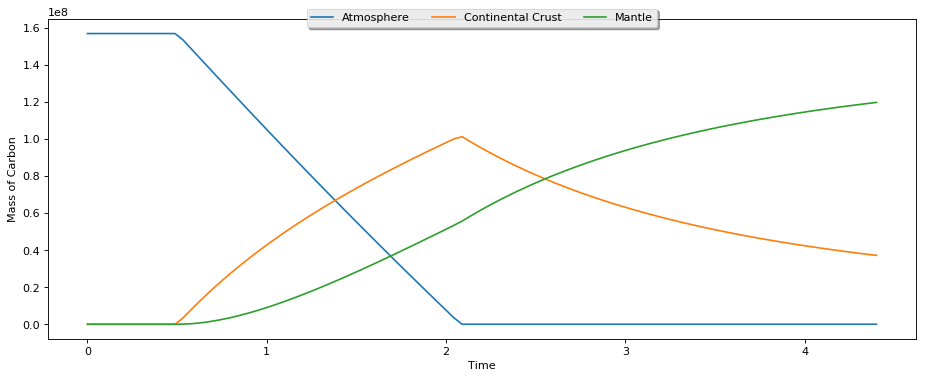

In [5]:
def f(y, t, params):
    cMa, cMcc, cMm = y
    t_0, t_1, t_2, t_p, tf, tau_1, cMa0, cMmp, cFmap, cMccp, cFccmp = params
    
    if (t == t_2):
        cMa = cMa_t2
        
    if (t_0 <= t and t < t_1):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - 0,
                  0 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    else:
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - cMa0/tau_1,
                  cMa0/tau_1 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]

    return derivs

def g(y, t, params):
    cMa, cMcc, cMm = y
    t_0, t_1, t_2, t_p, tf, tau_1, cMa0, cMa_t2, cMcc_t2, cMm_t2, cMmp, cFmap, cMccp, cFccmp = params
    
    if (t == t_2):
        cMa = cMa_t2
        cMcc = cMcc_t2
        cMm = cMm_t2
        
    if (t_0 <= t and t < t_1):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - 0,
                  0 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    elif (t_1 <= t and t < t_2):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - cMa0/tau_1,
                  cMa0/tau_1 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    else:
        derivs = [0,
                 0 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                 ((cMcc/cMccp)*cFccmp)*exp((t_p-t)/tf)]

    return derivs

def assemble_solve_ode(cMa0, cFccmp):
    # Parameters
    t_0 = 0   #Gyr
    t_1 = 0.5 #Gyr
    t_p = 4.4  #Gyr

    tau_1 = 1.5 #Gyr
    t_2 = 2.1
    tf = 3.61
    ts = 1e2

    cFmap = (cFccmp/1000)*1e9 #Gt/Gyr
    cMmp = 1.15e8
    cFccmp = (cFccmp/1000)*1e9 #Gt/Gyr
    cMccp = 4.2e7

    # Initial values
    cMcc0 = 0
    cMm0 = 0

    # Bundle parameters for ODE solver
    params = [t_0, t_1, t_2, t_p, tf, tau_1, cMa0, cMmp, cFmap, cMccp, cFccmp]
    
    # Bundle initial conditions for ODE solver
    y0 = [cMa0, cMcc0, cMm0]

    t = np.linspace(t_0,t_p,ts)
    solution = odeint(f, y0, t, args=(params,))
    
    solution_interpolant = interp1d(t, solution[:,0], 'cubic')
    cMa_t2 = 0
    t_2, = fsolve(lambda t: cMa_t2 - solution_interpolant(t), 2)
#     print(t_2)

    # Bundle parameters for ODE solver
    solution_interpolant_cMcc = interp1d(t, solution[:,1], 'cubic')
    solution_interpolant_cMm = interp1d(t, solution[:,2], 'cubic')
    cMcc_t2 = solution_interpolant_cMcc(t_2)
    cMm_t2 = solution_interpolant_cMcc(t_2)
    
    # Rebundle parameters for ODE solver with intial conditions at time t2
    params = [t_0, t_1, t_2, t_p, tf, tau_1, cMa0, cMa_t2, cMcc_t2, cMm_t2, cMmp, cFmap, cMccp, cFccmp]

    solution = odeint(g, y0, t, args=(params,))
    
    graph(t,solution)
    #return solution
    
# cMa_t2_widget = widgets.FloatSlider(min=1e0,max=1e8,step=1e2,value=5e4, description="$^cM_{a}(t_2)$", readout_format=".2g")
# cMa_t0_widget = widgets.FloatSlider(min=0.42e8,max=1.57e8,step=1e6,value=1.57e8, description="$^cM_{a}(t_0)$", readout_format=".3g")
# cFccmp_widget = widgets.FloatSlider(min=0,max=40,step=2,value=13, description="$^cF_{ccmp}$", readout_format=".3g")

# w = widgets.interactive(assemble_solve_ode,
#                         cMa0 = cMa_t0_widget,
#                         cFccmp = cFccmp_widget)

# display(w) 

# for i in range(0,40):
#     solution = assemble_solve_ode(cMa0=1.57e8, cFccmp=i)
#     if (solution[:,1][-1] <= 4.2e7):
#         print(i)
#         break

assemble_solve_ode(1.57e8, 13)

At $t_0 \le t < t_1$, 

\begin{array}
  {\partial M_a}\over{\partial t} &= 0, \\
  \frac{\partial M_{cc}}{\partial t} &= 0, \\
  \frac{\partial M_{m}}{\partial t} &= 0
\end{array}

At $t_1 \le t < t_2$, 

\begin{array}
  {\partial M_a}\over{\partial t} &= \frac{^cM_m}{^cM_{mp}} ^cF_{(m-a)p} e^{\frac{t_p - t}{t_f}} - \frac{^cM_{a0}}{\tau_1}, \\
  \frac{\partial M_{cc}}{\partial t} &= \frac{^cM_{a0}}{\tau_1} - \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} e^{\frac{t_p - t}{t_f}}, \\
  \frac{\partial M_{m}}{\partial t} &= ( \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} -\frac{^cM_m}{^cM_{mp}} ^cF_{(m-a)p} ) e^{\frac{t_p - t}{t_f}}
\end{array}

At $t_2 \le t < t_p$, 

\begin{array}
  {\partial M_a}\over{\partial t} &= 0, \\
  \frac{\partial M_{cc}}{\partial t} &= 0 - \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} e^{\frac{t_p - t}{t_f}}, \\
  \frac{\partial M_{m}}{\partial t} &= ( \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} ) e^{\frac{t_p - t}{t_f}}
\end{array}

where

\begin{array}
    ^cF_{(m-a)p} &= 13 \quad \text{Mt/yr}, \\
    ^cF_{(cc-m)p} &= 13 \quad \text{Mt/yr}, \\
    ^cF_{(m-a)p} &= 36 \quad \text{Mt/yr}, \\
    t_p &= 4.4 \quad \text{Gyr}, \\
    t_f &= 3.61 \quad \text{Gyr}, \\
    t_2 &= 2.1 \quad \text{Gyr}, \\
    \tau_1 &= 1.5 \quad \text{Gyr}, \\
    ^cM_{ccp} &= 4.2e7 \quad \text{Gt}, \\
    ^cM_{mp} &= 1.15e8 \quad \text{Gt}, \\
\end{array}

and the initial conditions at $t=t_0$ are
\begin{array}
    ^cM_{a0} &= 1.15e8 \quad \text{Gt}, \\
    ^cM_{cc0} &= 0.42e8 \quad \text{Gt}, \\
    ^cM_{m0} &= 0 \quad \text{Gt}, \\
\end{array}

TODO:
Add interpolant function to determine the exact $t_2$ at which $^cM_{a} = 0$.

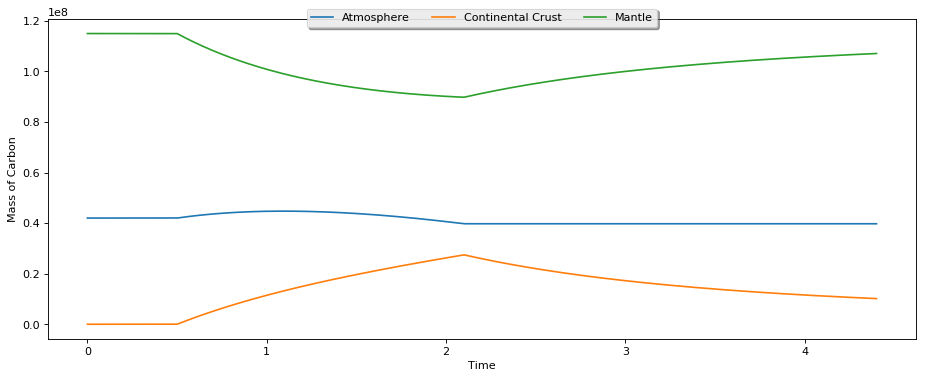

In [11]:
from scipy.integrate import odeint
#help(odeint)    # Uncomment to view the help file for this function

def calc_t_2(cMa0, cMa_2, t_1, tau_1):
    return tau_1 * (-(cMa_2/cMa0) + 1) + t_1

def f(y, t, params):
    cMa, cMcc, cMm = y
    t_0, t_1, t_2, t_p, tf, tau_1, cMa0, cMmp, cFmap, cMccp, cFccmp = params
    #tau, cMmp, cFmap, cMccp, cFccmp, tp, tf = params
    
    if (t == t_2):
        cMa = cMa_t2
        
    if (t_0 <= t and t < t_1):
        derivs = [0,
                  0,
                  0]
    elif (t_1 <= t and t < t_2):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - cMa0/tau_1,
                  cMa0/tau_1 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    else:
        derivs = [0,
                 0 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                 ((cMcc/cMccp)*cFccmp)*exp((t_p-t)/tf)]

    return derivs

def assemble_solve_ode(cMa0, cFccmp):
    # Parameters
    t_0 = 0   #Gyr
    t_1 = 0.5 #Gyr
    t_p = 4.4  #Gyr

    tau_1 = 1.5 #Gyr
    cMa_t2 = 0 #Gt
    t_2 = 2.1
    tf = 3.61
    ts = 1e4

    cFmap = (cFccmp/1000)*1e9 #Gt/Gyr
    cMmp = 1.15e8
    cFccmp = (cFccmp/1000)*1e9 #Gt/Gyr
    cMccp = 4.2e7

    # Initial values
    cMcc0 = 0
    cMm0 = 1.15e8

    # Bundle parameters for ODE solver
    params = [t_0, t_1, t_2, t_p, tf, tau_1, cMa0, cMmp, cFmap, cMccp, cFccmp]
    
    # Bundle initial conditions for ODE solver
    y0 = [cMa0, cMcc0, cMm0]

    t = np.linspace(t_0,t_p,ts)
    solution = odeint(f, y0, t, args=(params,))
    graph(t,solution)
#     return solution
    
# cMa_t2_widget = widgets.FloatSlider(min=1e0,max=1e8,step=1e2,value=5e4, description="$^cM_{a}(t_2)$", readout_format=".2g")
# cMa_t0_widget = widgets.FloatSlider(min=0.42e8,max=1.57e8,step=1e6,value=1.57e8, description="$^cM_{a}(t_0)$", readout_format=".3g")
# cFccmp_widget = widgets.FloatSlider(min=0,max=40,step=2,value=13, description="$^cF_{ccmp}$", readout_format=".3g")

# w = widgets.interactive(assemble_solve_ode,
#                         cMa0 = cMa_t0_widget,
#                         cFccmp = cFccmp_widget)

# display(w) 

# for i in range(0,40):
#     solution = assemble_solve_ode(cMa0=1.57e8, cFccmp=i)
#     if (solution[:,1][-1] <= 4.2e7):
#         print(i)
#         break

assemble_solve_ode(0.42e8, 13)

At $t_0 \le t < t_1$, 

\begin{array}
  {\partial M_a}\over{\partial t} &= \frac{^cM_m}{^cM_{mp}} ^cF_{(m-a)p} e^{\frac{t_p - t}{t_f}} - 0, \\
  \frac{\partial M_{cc}}{\partial t} &= 0 - \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} e^{\frac{t_p - t}{t_f}}, \\
  \frac{\partial M_{m}}{\partial t} &= ( \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} -\frac{^cM_m}{^cM_{mp}} ^cF_{(m-a)p} ) e^{\frac{t_p - t}{t_f}}
\end{array}

At $t_1 \le t < t_2$, 

\begin{array}
  {\partial M_a}\over{\partial t} &= \frac{^cM_m}{^cM_{mp}} ^cF_{(m-a)p} e^{\frac{t_p - t}{t_f}} - \frac{^cM_{a0}}{\tau_1} - ^cF_{(a-m)p}, \\
  \frac{\partial M_{cc}}{\partial t} &= \frac{^cM_{a0}}{\tau_1} + ^cF_{(a-m)p} - \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} e^{\frac{t_p - t}{t_f}}, \\
  \frac{\partial M_{m}}{\partial t} &= ( \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} -\frac{^cM_m}{^cM_{mp}} ^cF_{(m-a)p} ) e^{\frac{t_p - t}{t_f}}
\end{array}

At $t_2 \le t < t_p$, 

\begin{array}
  {\partial M_a}\over{\partial t} &= 0, \\
  \frac{\partial M_{cc}}{\partial t} &= 0 - \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} e^{\frac{t_p - t}{t_f}}, \\
  \frac{\partial M_{m}}{\partial t} &= ( \frac{^cM_{cc}}{^cM_{ccp}} ^cF_{(cc-m)p} ) e^{\frac{t_p - t}{t_f}}
\end{array}

where

\begin{array}
    ^cF_{(m-a)p} &= 15 \quad \text{Mt/yr}, \\
    ^cF_{(cc-m)p} &= 15 \quad \text{Mt/yr}, \\
    ^cF_{(a-m)p} &= 34 \quad \text{Mt/yr}. \\
    t_p &= 4.4 \quad \text{Gyr}, \\
    t_f &= 3.61 \quad \text{Gyr}, \\
    t_2 &= 1.69 \quad \text{Gyr}, \\
    \tau_1 &= 1.5 \quad \text{Gyr}, \\
    ^cM_{ccp} &= 4.2e7 \quad \text{Gt}, \\
    ^cM_{mp} &= 1.15e8 \quad \text{Gt}, \\
\end{array}

and the initial conditions at $t=t_0$ are
\begin{array}
    ^cM_{a0} &= 1.57e8 \quad \text{Gt}, \\
    ^cM_{cc0} &= 0 \quad \text{Gt}, \\
    ^cM_{m0} &= 0 \quad \text{Gt}, \\
\end{array}

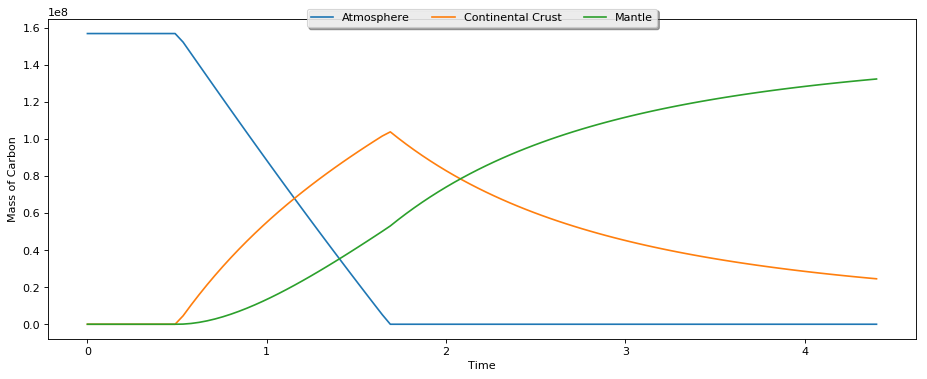

In [7]:
def f(y, t, params):
    cMa, cMcc, cMm = y
    t_0, t_1, t_2, t_p, tf, tau_1, cMa0, cMmp, cFmap, cMccp, cFccmp, cFamp = params
    #tau, cMmp, cFmap, cMccp, cFccmp, tp, tf = params
    
    if (t == t_2):
        cMa = cMa_t2
        
    if (t_0 <= t and t < t_1):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - 0,
                  0 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    else:
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - cMa0/tau_1 - cFamp,
                  cMa0/tau_1 + cFamp - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]

    return derivs

def g(y, t, params):
    cMa, cMcc, cMm = y
    t_0, t_1, t_2, t_p, tf, tau_1, cMa0, cMa_t2, cMcc_t2, cMm_t2, cMmp, cFmap, cMccp, cFccmp, cFamp = params
    
    if (t == t_2):
        cMa = cMa_t2
        cMcc = cMcc_t2
        cMm = cMm_t2
        
    if (t_0 <= t and t < t_1):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - 0,
                  0 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    elif (t_1 <= t and t < t_2):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - cMa0/tau_1 - cFamp,
                  cMa0/tau_1 + cFamp - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    else:
        derivs = [0,
                 -(cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                 ((cMcc/cMccp)*cFccmp)*exp((t_p-t)/tf)]

    return derivs

def assemble_solve_ode(cMa0, cFccmp, cFamp):
    # Parameters
    t_0 = 0   #Gyr
    t_1 = 0.5 #Gyr
    t_p = 4.4  #Gyr

    tau_1 = 1.5 #Gyr
    t_2 = 2.1
    tf = 3.61 #Gyr
    ts = 1e2

    cFmap = (cFccmp/1000)*1e9 #Gt/Gyr
    cFamp = (cFamp/1000)*1e9 #Gt/Gyr
    cMmp = 1.15e8 #Gt
    cFccmp = (cFccmp/1000)*1e9 #Gt/Gyr
    cMccp = 4.2e7 #Gt

    # Initial values
    cMcc0 = 0
    cMm0 = 0

    # Bundle parameters for ODE solver
    params = [t_0, t_1, t_2, t_p, tf, tau_1, cMa0, cMmp, cFmap, cMccp, cFccmp, cFamp]
    
    # Bundle initial conditions for ODE solver
    y0 = [cMa0, cMcc0, cMm0]

    t = np.linspace(t_0,t_p,ts)
    solution = odeint(f, y0, t, args=(params,))
    
    solution_interpolant = interp1d(t, solution[:,0], 'cubic')
    cMa_t2 = 0
    t_2, = fsolve(lambda t: cMa_t2 - solution_interpolant(t), 2)
#     print(t_2)

    # Bundle parameters for ODE solver
    solution_interpolant_cMcc = interp1d(t, solution[:,1], 'cubic')
    solution_interpolant_cMm = interp1d(t, solution[:,2], 'cubic')
    cMcc_t2 = solution_interpolant_cMcc(t_2)
    cMm_t2 = solution_interpolant_cMcc(t_2)
    
    # Rebundle parameters for ODE solver with intial conditions at time t2
    #params = [t_0, t_1, t_2, t_p, tf, tau_1, cMa0, cMmp, cFmap, cMccp, cFccmp, cFamp]
    params = [t_0, t_1, t_2, t_p, tf, tau_1, cMa0, cMa_t2, cMcc_t2, cMm_t2, cMmp, cFmap, cMccp, cFccmp, cFamp]
    
    # Bundle initial conditions for ODE solver
    y0 = [cMa0, cMcc0, cMm0]

    solution = odeint(g, y0, t, args=(params,))
    
    graph(t,solution)
#     return solution
    
# cMa_t2_widget = widgets.FloatSlider(min=1e0,max=1e8,step=1e2,value=5e4, description="$^cM_{a}(t_2)$", readout_format=".2g")
# cMa_t0_widget = widgets.FloatSlider(min=0.42e8,max=1.57e8,step=1e6,value=1.57e8, description="$^cM_{a}(t_0)$", readout_format=".3g")
# cFccmp_widget = widgets.FloatSlider(min=0,max=40,step=2,value=13, description="$^cF_{ccmp}$", readout_format=".3g")

# w = widgets.interactive(assemble_solve_ode,
#                         cMa0 = cMa_t0_widget,
#                         cFccmp = cFccmp_widget)

# display(w) 

# for i in range(0,40):
#     solution = assemble_solve_ode(cMa0=1.57e8, cFccmp=i, cFamp=34)
#     if (solution[:,1][-1] <= 4.2e7):
#         print(i)
#         break

assemble_solve_ode(1.57e8, 15, 34)